Install HPI tool and get trainings-data

In [1]:
%tensorflow_version 2.x # Befehl für Google Colab für Tensorflow 2

# ohne Ausrufezeichen bei Ausführung im lokalen Notebook
!pip install --upgrade deeplearning2020
from deeplearning2020.datasets import ImageWoof

train_data, test_data, classes = ImageWoof.load_data()

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Befehl für Google Colab für Tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
     |████████████████████████████████| 399kB 4.2MB/s 
  Created wheel for deeplearning2020: filename=deeplearning2020-0.4.21-py2.py3-none-any.whl size=8548 sha256=50e0affea7431ec4a943fd5cbca84b7c42159ca94cb514bd83544cd3fca8dd79
  Stored in directory: /root/.cache/pip/wheels/7f/c2/8a/f9f03fc839999f1fe9d5e5a9d2c97cdd5cb8329f61f82ea2c9
  Created wheel for kerasltisubmission: filename=kerasltisubmission-0.4.9-py2.py3-none-any.whl size=8867 sha256=da096ad17801a40eaced6a1304adffba4a5e7a88e31934a14fa310ed9e909ed8
  Stored in directory: /root/.cache/pip/wheels/fd/61/f7/09171376b25408ae21b58e98c9fbf2eb924f676bb77659f983
Successfully built deeplearning2020 kerasltisubmission
328294400/328288506 [==============================] - 3s 0us/step
/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.

Init *Tensorflow* and stuff

In [2]:
# TensorFlow ≥2.0 wird benötigt
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
  print("GPU ok")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, \
  Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from deeplearning2020 import helpers

# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
%matplotlib inline

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU ok


Define the preprocessor

In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [300, 300])
    return resized_image, label

Resize the pictures and prepare batch

In [5]:
# Festlegung der Batch Größe für die Datenvorbereitung
batch_size = 32 

# Durchmischen der Trainingsdaten, dass nicht mit sortierten Bildern trainiert wird 
train_data = train_data.shuffle(1000) 

print('shape des Trainigsdatensatzes vor dem preprocessing: ', train_data)

train_data = train_data.map(preprocess) \
  .batch(batch_size).prefetch(1)          
test_data = test_data.map(preprocess) \
  .batch(batch_size).prefetch(1)

print('shape des Traingingsdatensatzes nach dem preprocessing: ', train_data)

shape des Trainigsdatensatzes vor dem preprocessing:  <ShuffleDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
shape des Traingingsdatensatzes nach dem preprocessing:  <PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


Show train data

In [0]:
#helpers.plot_images(train_data.unbatch().take(9), classes)

Define the net

In [15]:
# model
learning_rate=0.003
momentum=0.9
decay=0.001
dense_neurons=1000
n_filters=32
first_kernel_size=(7,7)

n_classes=len(classes)

activation='elu'

# Inputgröße muss 300x300 Pixel mit 3 RGB Farben betragen
input_layer = Input(shape=(300, 300, 3))
input = BatchNormalization(axis=[1,2])(input_layer)

# Convolutional Neural Network
# Entry Convolutional Layers (with pooling)
model = Conv2D(filters=n_filters, kernel_size=first_kernel_size, activation=activation )(input)
model = BatchNormalization(axis=[1,2])(model)
model = MaxPooling2D((2,2))(model)

# 4 Conv layer (with pooling)
for i in range(2, 5):
  model = Conv2D(filters = i * n_filters, kernel_size=(3,3), activation=activation)(model)
  #model = Conv2D(filters = i * n_filters, kernel_size=(3,3), activation=activation, padding='same')(model)
  model = BatchNormalization(axis=[1,2])(model)
  model = MaxPooling2D((2,2))(model)

# final conv & pooling
model = Conv2D(filters = 5 * n_filters, kernel_size=(3,3), activation=activation, padding='same')(model)
model = BatchNormalization(axis=[1,2])(model)
model = MaxPooling2D((2,2))(model)

# Fully-Connected-Classifier
model = Flatten()(model)
model = Dense(dense_neurons, activation=activation)(model)
model = BatchNormalization()(model)
model = Dropout(0.5)(model)

# Fully connected layer
model = Dense(dense_neurons / 2, activation='tanh')(model)
model = BatchNormalization()(model)
model = Dropout(0.5)(model)

# Output Layer
output = Dense(n_classes, activation="softmax")(model)

#Full model
CNN_model = Model(input_layer, output)

# Kompilieren des Modells
## Stochastic Gradient Descent -> langsamer aber genauer
optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay)
## Adam -> schneller, für schnellere aber nicht 100% Ergebnisse
#optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
CNN_model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
CNN_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 300, 300, 3)       360000    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 294, 294, 32)      4736      
_________________________________________________________________
batch_normalization_25 (Batc (None, 294, 294, 32)      345744    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 147, 147, 32)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 145, 145, 64)      18496     
_________________________________________________________________
batch_normalization_26 (Batc (None, 145, 145, 64)      8410

Training

In [17]:
# Training des Modells
history = CNN_model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)

Epoch 1/10
283/283 [==============================] - 154s 543ms/step - loss: 1.6089 - accuracy: 0.4331 - val_loss: 1.6807 - val_accuracy: 0.4220
Epoch 2/10
283/283 [==============================] - 154s 543ms/step - loss: 1.5606 - accuracy: 0.4422 - val_loss: 1.6464 - val_accuracy: 0.4378
Epoch 3/10
283/283 [==============================] - 154s 543ms/step - loss: 1.5156 - accuracy: 0.4709 - val_loss: 1.7103 - val_accuracy: 0.4146
Epoch 4/10
283/283 [==============================] - 154s 544ms/step - loss: 1.4606 - accuracy: 0.4847 - val_loss: 1.6411 - val_accuracy: 0.4439
Epoch 5/10
283/283 [==============================] - 154s 543ms/step - loss: 1.4298 - accuracy: 0.5005 - val_loss: 1.6263 - val_accuracy: 0.4543
Epoch 6/10
283/283 [==============================] - 154s 544ms/step - loss: 1.3898 - accuracy: 0.5163 - val_loss: 1.6633 - val_accuracy: 0.4477
Epoch 7/10
283/283 [==============================] - 154s 544ms/step - loss: 1.3447 - accuracy: 0.5275 - val_loss: 1.6528 -

Tranings-Ergebnis anzeigen

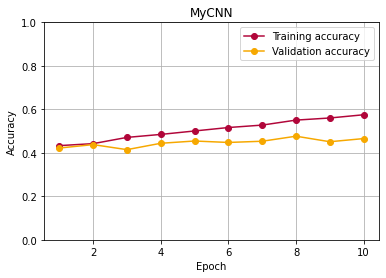

In [18]:
helpers.plot_history('MyCNN', history, 0)

Submission

In [19]:
from deeplearning2020 import Submission
Submission('4d712a6d0ae14f2a395c992ad3627476', '3', CNN_model).submit()

Using TensorFlow backend.


Model wird validiert...


100% (200 of 200) |######################| Elapsed Time: 0:07:15 Time:  0:07:15


Assignment 3 erfolgreich abgegeben!
Dein Model hat eine Accuracy von 46.0% auf unseren Validierungsdaten.
Du erhältst 48.0% der Punkte auf dieses Assignment.
Falls du bereits eine Abgabe mit höherer Bewertung abgegeben hast, wird automatisch das bessere Ergebnis gewählt.
